<a href="https://colab.research.google.com/github/AmeenReda1/Sartorius---Cell-Instance-Segmentation/blob/main/Sartorius_Cell_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install wget
#import wget
#wget.download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/30201/2750748/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1637092858&Signature=OBFT0xI5O0UbP3FgPcPXBSmSdISb0VrnzUiCaGZz81ryUoh%2FcRIIkWHbOiaF3xLyhE%2Bp5o5TWDaKiM66tmfMqzFFLqxFrsgP0yC5YrWI8NsHRLzlAiAT%2FYfHFIsDqAhS6Tq83Hl7hezuFxKNBmy4ilgpHRdt1ZDsXExaztBFp%2BC9uI%2FcL0esfyfUnOiV6gpxmsH0XrZ%2B8%2B6BZtK3W2rraYiv4whMC1GHaSLq64om90ttDfjfQ%2F2Xx1XtIuEBmJQSQUKLRLpIQ3TOWS115y9WC1jGojfKkYUzMI6UAj1jAF%2BdtCGEGnqr8zibbq%2FJybGkPrxtHClBtMudn198yB%2FeUQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dsartorius-cell-instance-segmentation.zip")
#!unzip "/content/drive/MyDrive/sartorius-cell-instance-segmentation.zip" -d "/content/drive/MyDrive/sartorius-cell-instance-segmentation"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tqdm
import cv2
import seaborn as sns
import glob
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/sartorius-cell-instance-segmentation/train.csv')
datacopy=data.copy()
print(len(data))
data.head()

In [ ]:
all_lables=["annotation","width","height","plate_time","sample_date","sample_id","elapsed_timedelta"]
datacopy=datacopy.drop(all_lables,axis=1)
datacopy.head()

In [ ]:
datacopy.drop_duplicates(subset="id",keep="first",inplace=True)
print(len(datacopy))
datacopy.to_csv("/content/drive/MyDrive/sartorius-cell-instance-segmentation.csv",index=False)
datacopy.head()

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

In [ ]:
data.info()

In [ ]:
# dropping ALL duplicate values
print(len(data))
theData=data.copy()
theData.drop_duplicates(subset ="id",
                     keep = "first", inplace = True)
print(len(theData))
print(len(data))
all_lables=["annotation","width","height","plate_time","sample_date","sample_id","elapsed_timedelta"]
theData=theData.drop(all_lables,axis=1)
print(theData.head())


In [ ]:
sns.countplot(x= "cell_type", data= theData)
plt.title("Cell type counting")
plt.show()
print(theData["cell_type"].value_counts())

In [ ]:
file_names = data['id'].unique()
print(len(file_names))

# Rle_decode method colord annotation with white

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths =s[0:][::2], s[1:][::2]
    starts=np.array(starts,dtype=int)
    lengths=np.array(lengths,dtype=int)
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    print(img)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)
   

In [ ]:
# tqdm is a library to make a progress bar
sum = 0
for file in tqdm.tqdm(file_names):
    main_image = np.zeros(520*704, dtype=np.float32)
    main_image = main_image.reshape((520,704))
    get_all_codes = data[data['id'] == file]
    get_all_codes = get_all_codes.reset_index()
    location = '/content/drive/MyDrive/sartorius-cell-instance-segmentation/after_mask/'
    for d in range(len(get_all_codes)):
        try:
            shape=(get_all_codes.loc[d]['height'],get_all_codes.loc[d]['width'])
            im = rle_decode(get_all_codes.loc[d]['annotation'],shape)
            main_image = cv2.bitwise_or(main_image,im)
        except Exception as e:
            sum+=1
    # save masks as png image
    cv2.imwrite(location+file+'.png',main_image)

In [ ]:
image = cv2.imread('/content/drive/MyDrive/sartorius-cell-instance-segmentation/train/0a6ecc5fe78a.png',1)
print(image.shape)
plt.imshow(image)

In [ ]:
image = cv2.imread('/content/drive/MyDrive/sartorius-cell-instance-segmentation/after_mask/0a6ecc5fe78a.png',0)
plt.imshow(image,'Greys')
print(image.shape)

# split colored Data to three folders


In [ ]:
import os,glob
# for loop in after mask and put the id with here image
the_folder_path="/content/drive/MyDrive/sartorius-cell-instance-segmentation/train/"
# print(glob.glob(os.path.join(the_folder_path,"*.png")))
print(theData.head())
print(len(theData))
ids=[]
images=[]
for image_path in glob.glob(os.path.join(the_folder_path,"*.png")):
  current_image=image_path.split('/')[-1]
  ids.append(current_image[:-4])
  img=cv2.imread(image_path)
  images.append(img)
print(len(ids))
print(len(images))

In [ ]:
DataFor_colord_images=pd.DataFrame({'id':ids,'image':images})
print(DataFor_colord_images.head())

In [ ]:
final_colord_data = pd.merge(theData, DataFor_colord_images, on="id")
final_colord_data.head()

In [ ]:
final_colord_data.to_csv("/content/drive/MyDrive/sartorius-cell-instance-segmentation/final_colord_data.csv")

In [ ]:
first_path="/content/final_colored_cells/shsy5y/"
second_path="/content/final_colored_cells/cort/"
third_path="/content/final_colored_cells/astro/"
for i in range(len(final_colord_data)):
  
  if final_colord_data['cell_type'][i] =="shsy5y":
    cv2.imwrite(first_path+final_colord_data['id'][i]+'.png',final_colord_data['image'][i])
  elif final_colord_data['cell_type'][i] =="cort":
    cv2.imwrite(second_path+final_colord_data['id'][i]+'.png',final_colord_data['image'][i])
  elif final_colord_data['cell_type'][i] =="astro":  
    cv2.imwrite(third_path+final_colord_data['id'][i]+'.png',final_colord_data['image'][i])

# **Split Data to Three Folders**

In [ ]:
import os,glob
# for loop in after mask and put the id with here image
the_folder_path="/content/drive/MyDrive/sartorius-cell-instance-segmentation/after_mask/"
# print(glob.glob(os.path.join(the_folder_path,"*.png")))
print(theData.head())
print(len(theData))
ids=[]
images=[]
for image_path in glob.glob(os.path.join(the_folder_path,"*.png")):
  current_image=image_path.split('/')[-1]
  ids.append(current_image[:-4])
  img=cv2.imread(image_path)
  images.append(img)
print(len(ids))
print(len(images))


In [ ]:
DataFor_images=pd.DataFrame({'id':ids,'image':images})
print(DataFor_images.head())


In [ ]:
final_data = pd.merge(theData, DataFor_images, on="id")
final_data.head()

In [ ]:
final_data.to_csv("/content/drive/MyDrive/sartorius-cell-instance-segmentation/final_data.csv")

In [ ]:
# !rm -rf /content/drive/MyDrive/sartorius-cell-instance-segmentation/cells

In [ ]:
first_path="/content/drive/MyDrive/sartorius-cell-instance-segmentation/cells/shsy5y/"
second_path="/content/drive/MyDrive/sartorius-cell-instance-segmentation/cells/cort/"
third_path="/content/drive/MyDrive/sartorius-cell-instance-segmentation/cells/astro/"
for i in range(len(final_data)):
  
  if final_data['cell_type'][i] =="shsy5y":
    cv2.imwrite(first_path+final_data['id'][i]+'.png',final_data['image'][i])
  elif final_data['cell_type'][i] =="cort":
    cv2.imwrite(second_path+final_data['id'][i]+'.png',final_data['image'][i])
  elif final_data['cell_type'][i] =="astro":  
    cv2.imwrite(third_path+final_data['id'][i]+'.png',final_data['image'][i])

#Make DataFrame For Testing

In [3]:
import os
the_test_data_path="/content/drive/MyDrive/sartorius-cell-instance-segmentation/test_colored_data/*"
images_list=[]
label_list=[]

for directory_path in glob.glob(the_test_data_path):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path)       
        images_list.append(img)
        if label=="astro":
          label_list.append(0)
        elif label=="cort":
          label_list.append(1)
        elif label=="shsy5y":
          label_list.append(2)  
testDataframe=pd.DataFrame({"image":images_list,"label":label_list})
testDataframe.head()

,image,label
0,"[[[127, 127, 127], [127, 127, 127], [130, 130,...",0
1,"[[[124, 124, 124], [125, 125, 125], [129, 129,...",0
2,"[[[126, 126, 126], [127, 127, 127], [128, 128,...",0
3,"[[[131, 131, 131], [131, 131, 131], [125, 125,...",0
4,"[[[127, 127, 127], [127, 127, 127], [127, 127,...",0


In [4]:
images_list=np.array(images_list)
labels_list=np.array(label_list)
print(type(images_list))
print(type(labels_list))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#John Adel ResNET50

In [8]:
cd /content/drive/MyDrive/sartorius-cell-instance-segmentation/colored_cells

/content/drive/MyDrive/sartorius-cell-instance-segmentation/colored_cells


In [5]:
ls 

drive/  sample_data/


In [6]:
data_dir="/content/drive/MyDrive/sartorius-cell-instance-segmentation/colored_cells/"
img_height,img_width=520,704
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 546 files belonging to 3 classes.
Using 437 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 546 files belonging to 3 classes.
Using 109 files for validation.


In [8]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(520,704,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [9]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(layers.Dropout(rate=0.2))
resnet_model.add(Dense(3, activation='softmax'))

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 1,050,627
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
resnet_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_resnet50 = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[callback])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


14/14 [==============================] - 587s 41s/step - loss: 0.3602 - accuracy: 0.8970 - val_loss: 0.1988 - val_accuracy: 0.9358
Epoch 2/10
14/14 [==============================] - 559s 40s/step - loss: 0.0757 - accuracy: 0.9748 - val_loss: 0.0818 - val_accuracy: 0.9725
Epoch 3/10
14/14 [==============================] - 561s 40s/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 573s 41s/step - loss: 0.0102 - accuracy: 0.9954 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 571s 41s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 571s 41s/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 570s 41s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000


In [12]:
result_resnet=resnet_model.predict(images_list)
y_pred_resnet = np.argmax(result_resnet, axis=1)
target_names=["astro","cort","shsy5y"]
print(classification_report(y_pred_resnet, label_list, target_names=target_names))

              precision    recall  f1-score   support

       astro       1.00      1.00      1.00        20
        cort       1.00      1.00      1.00        20
      shsy5y       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



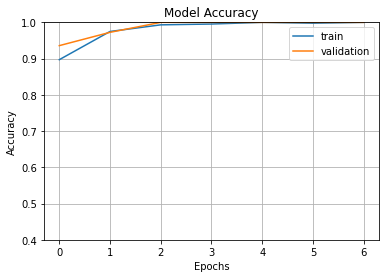

In [13]:
fig1 = plt.gcf()
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

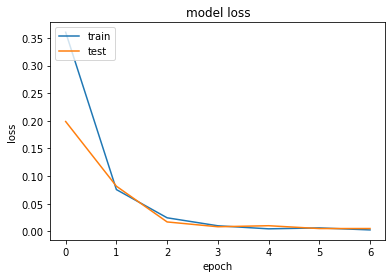

In [14]:
# summarize history for loss
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Ameen Reda VGG-16



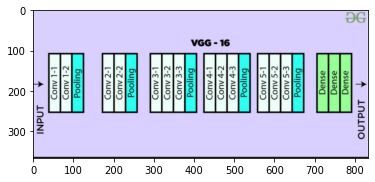

In [15]:
vgg_16_image=cv2.imread("/content/drive/MyDrive/sartorius-cell-instance-segmentation/VGG-16.png",1)
plt.imshow(vgg_16_image)

In [19]:
VGG16 = Sequential()
pretrained_model_vGG=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(520,704,3),
    pooling="max",
    classes=3,
    classifier_activation="softmax",
)
for layer in pretrained_model_vGG.layers:
        layer.trainable=False

In [20]:
VGG16.add(pretrained_model_vGG)
VGG16.add(Flatten())
VGG16.add(Dense(512, activation='relu'))
VGG16.add(layers.Dropout(rate=0.2))
VGG16.add(Dense(512, activation='relu'))
VGG16.add(Dense(3, activation='softmax'))

In [21]:
VGG16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 15,241,539
Trainable params: 526,851
Non

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
VGG16.compile(optimizer=Adam(lr=0.001),loss="sparse_categorical_crossentropy",metrics=['accuracy'])
history_VGG16 = VGG16.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
14/14 [==============================] - 1825s 132s/step - loss: 14.5929 - accuracy: 0.7323 - val_loss: 3.2505 - val_accuracy: 0.9266
Epoch 2/10
14/14 [==============================] - 1824s 132s/step - loss: 1.9709 - accuracy: 0.9153 - val_loss: 2.2247 - val_accuracy: 0.9541
Epoch 3/10
14/14 [==============================] - 1836s 132s/step - loss: 0.9888 - accuracy: 0.9657 - val_loss: 0.3034 - val_accuracy: 0.9725
Epoch 4/10
14/14 [==============================] - 1825s 132s/step - loss: 0.1572 - accuracy: 0.9771 - val_loss: 0.3361 - val_accuracy: 0.9817
Epoch 5/10
14/14 [==============================] - 1832s 132s/step - loss: 0.0406 - accuracy: 0.9908 - val_loss: 0.2521 - val_accuracy: 0.9817
Epoch 6/10
14/14 [==============================] - 1833s 132s/step - loss: 0.1035 - accuracy: 0.9794 - val_loss: 0.2746 - val_accuracy: 0.9817
Epoch 7/10
14/14 [==============================] - 1839s 133s/step - loss: 0.1114 - accuracy: 0.9725 - val_loss: 0.3251 - val_accuracy

In [23]:
result_VGG16=VGG16.predict(images_list)
y_pred_VGG16 = np.argmax(result_VGG16, axis=1)
target_names=["astro","cort","shsy5y"]
print(classification_report(y_pred_VGG16, label_list, target_names=target_names))

              precision    recall  f1-score   support

       astro       0.80      1.00      0.89        16
        cort       1.00      1.00      1.00        20
      shsy5y       1.00      0.83      0.91        24

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.95      0.93      0.93        60



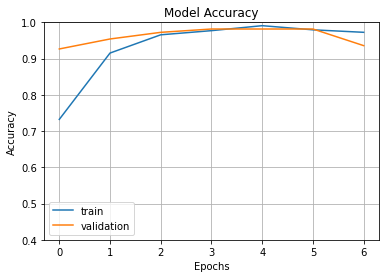

In [24]:
fig1 = plt.gcf()
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

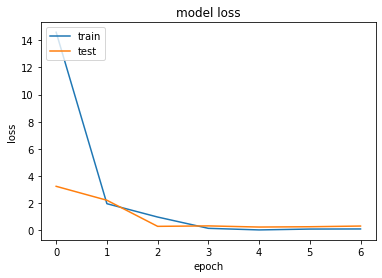

In [25]:
# summarize history for loss
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Nada Salah 

##CNN Nada Salah

In [8]:
from tensorflow.keras import datasets, layers, models

In [9]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(520,704, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(60, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(3, activation='softmax')
])

In [10]:
Adagrad=tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad"
)
cnn.compile(optimizer=Adagrad,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 518, 702, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 259, 351, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 349, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 174, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1425408)           0         
                                                                 
 dense (Dense)               (None, 60)                8

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history_cnn=cnn.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[callback])

Epoch 1/10
14/14 [==============================] - 233s 16s/step - loss: 1365.0450 - accuracy: 0.4439 - val_loss: 1.0936 - val_accuracy: 0.5688
Epoch 2/10
14/14 [==============================] - 221s 16s/step - loss: 1.0974 - accuracy: 0.5446 - val_loss: 1.0955 - val_accuracy: 0.5688
Epoch 3/10
14/14 [==============================] - 215s 15s/step - loss: 120.9448 - accuracy: 0.5446 - val_loss: 1.0944 - val_accuracy: 0.5688
Epoch 4/10
14/14 [==============================] - 213s 15s/step - loss: 1.0960 - accuracy: 0.5446 - val_loss: 1.0937 - val_accuracy: 0.5688
Epoch 5/10
14/14 [==============================] - 222s 15s/step - loss: 1.0957 - accuracy: 0.5423 - val_loss: 1.0931 - val_accuracy: 0.5688


In [13]:
result_cnn=cnn.predict(images_list)
y_pred_cnn = np.argmax(result_cnn, axis=1)
target_names=["astro","cort","shsy5y"]
print(classification_report(y_pred_cnn, label_list, target_names=target_names))

              precision    recall  f1-score   support

       astro       0.00      0.00      0.00         0
        cort       1.00      0.33      0.50        60
      shsy5y       0.00      0.00      0.00         0

    accuracy                           0.33        60
   macro avg       0.33      0.11      0.17        60
weighted avg       1.00      0.33      0.50        60



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


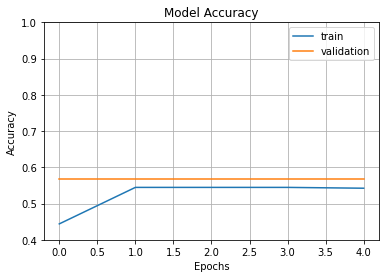

In [14]:
fig1 = plt.gcf()
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

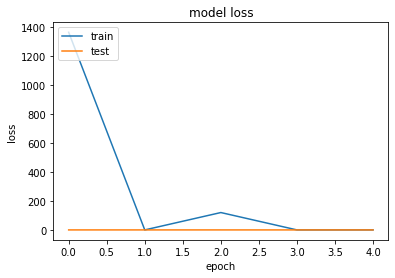

In [15]:
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#EfficientNetB0 Nada Salah

In [16]:
EfficientNetB0=Sequential()
pre_trained_EfficientNetB0=tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(520,704,3),
    pooling="avg",
    classes=3,
    classifier_activation="softmax",
)
for layer in pre_trained_EfficientNetB0.layers:
        layer.trainable=False

16719872/16705208 [==============================] - 0s 0us/step


In [17]:
EfficientNetB0.add(pre_trained_EfficientNetB0)
EfficientNetB0.add(Flatten())
EfficientNetB0.add(Dense(300, activation='relu')),
EfficientNetB0.add(layers.Dropout(rate=0.5)),
EfficientNetB0.add(Dense(250, activation='relu')),
EfficientNetB0.add(Dense(3, activation='softmax'))   
EfficientNetB0.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 300)               384300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 250)               75250     
                                                                 
 dense_4 (Dense)             (None, 3)                 753       
                                                                 
Total params: 4,509,874
Trainable params: 460,303
Non-

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
EfficientNetB0.compile(optimizer='SGD',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history_EfficientNetB0 = EfficientNetB0.fit(train_ds, validation_data=val_ds, epochs=15,callbacks=[callback])

Epoch 1/15
14/14 [==============================] - 203s 14s/step - loss: 0.9056 - accuracy: 0.6041 - val_loss: 0.6612 - val_accuracy: 0.7248
Epoch 2/15
14/14 [==============================] - 202s 14s/step - loss: 0.6435 - accuracy: 0.7757 - val_loss: 0.4770 - val_accuracy: 0.7615
Epoch 3/15
14/14 [==============================] - 218s 16s/step - loss: 0.4858 - accuracy: 0.8627 - val_loss: 0.3635 - val_accuracy: 0.8440
Epoch 4/15
14/14 [==============================] - 202s 14s/step - loss: 0.3991 - accuracy: 0.8696 - val_loss: 0.2740 - val_accuracy: 0.9358
Epoch 5/15
14/14 [==============================] - 226s 16s/step - loss: 0.3283 - accuracy: 0.9314 - val_loss: 0.2272 - val_accuracy: 0.9450
Epoch 6/15
14/14 [==============================] - 195s 14s/step - loss: 0.2818 - accuracy: 0.9336 - val_loss: 0.1876 - val_accuracy: 0.9541
Epoch 7/15
14/14 [==============================] - 220s 16s/step - loss: 0.2285 - accuracy: 0.9611 - val_loss: 0.1578 - val_accuracy: 0.9725
Epoch 

In [19]:
result_EfficientNetB0=EfficientNetB0.predict(images_list)
y_pred_EfficientNetB0 = np.argmax(result_EfficientNetB0, axis=1)
target_names=["astro","cort","shsy5y"]
print(classification_report(y_pred_EfficientNetB0, label_list, target_names=target_names))

              precision    recall  f1-score   support

       astro       1.00      1.00      1.00        20
        cort       1.00      1.00      1.00        20
      shsy5y       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



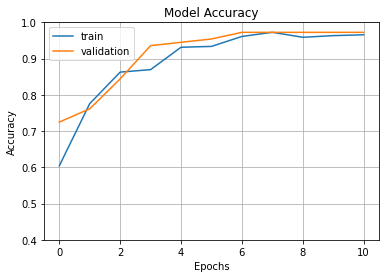

In [20]:
fig1 = plt.gcf()
plt.plot(history_EfficientNetB0.history['accuracy'])
plt.plot(history_EfficientNetB0.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

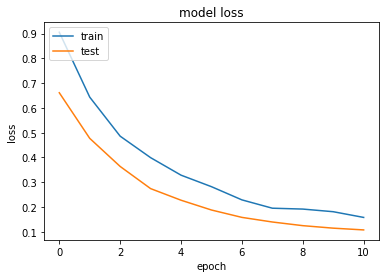

In [21]:
# summarize history for loss
plt.plot(history_EfficientNetB0.history['loss'])
plt.plot(history_EfficientNetB0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Mostafa Kafafy

In [22]:
Xception_model=Sequential()

Xception_pretrained_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(520,704,3),
    pooling="max",
    classes=3,
    classifier_activation="softmax",
)
for layer in Xception_pretrained_model.layers:
        layer.trainable=False

Xception_model.add(Xception_pretrained_model)
Xception_model.add(Flatten())
Xception_model.add(Dense(150, activation='relu'))
Xception_model.add(layers.Dropout(rate=0.2)),
Xception_model.add(Dense(3, activation='softmax'))   
Xception_model.summary() 

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 150)               307350    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 453       
                                                                 
Total params: 21,169,283
Trainable params: 307,803
Non-trainable params: 20,861,480
_____________________________________

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
Xception_model.compile(optimizer=Adam(lr=0.001),loss="sparse_categorical_crossentropy",metrics=['accuracy'])
history_Xception = Xception_model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
14/14 [==============================] - 752s 52s/step - loss: 58.3769 - accuracy: 0.5195 - val_loss: 8.5292 - val_accuracy: 0.8257
Epoch 2/10
14/14 [==============================] - 748s 54s/step - loss: 12.2398 - accuracy: 0.7941 - val_loss: 5.3374 - val_accuracy: 0.8807
Epoch 3/10
14/14 [==============================] - 659s 47s/step - loss: 5.3853 - accuracy: 0.8924 - val_loss: 3.4848 - val_accuracy: 0.8899
Epoch 4/10
14/14 [==============================] - 656s 47s/step - loss: 5.4158 - accuracy: 0.8581 - val_loss: 3.4913 - val_accuracy: 0.8807
Epoch 5/10
14/14 [==============================] - 661s 48s/step - loss: 3.4665 - accuracy: 0.8627 - val_loss: 2.9801 - val_accuracy: 0.8807


In [24]:
result_Xception=Xception_model.predict(images_list)
y_pred_Xception = np.argmax(result_Xception, axis=1)
target_names=["astro","cort","shsy5y"]
print(classification_report(y_pred_Xception, label_list, target_names=target_names))

              precision    recall  f1-score   support

       astro       0.90      0.90      0.90        20
        cort       1.00      0.83      0.91        24
      shsy5y       0.70      0.88      0.78        16

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.86        60
weighted avg       0.89      0.87      0.87        60



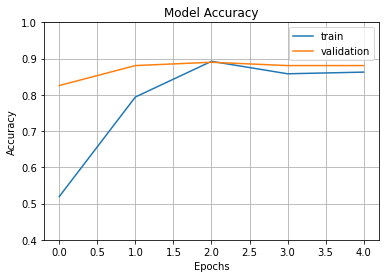

In [25]:
fig1 = plt.gcf()
plt.plot(history_Xception.history['accuracy'])
plt.plot(history_Xception.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

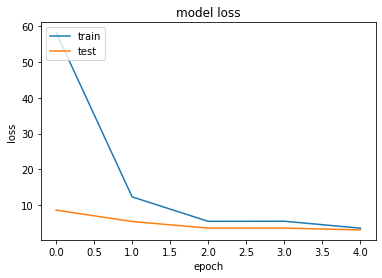

In [26]:
# summarize history for loss
plt.plot(history_Xception.history['loss'])
plt.plot(history_Xception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Mohamed Ehab

In [27]:
InceptionV3_model=Sequential()
InceptionV3__pretrained_model=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(520,704,3),
    pooling="max",
    classes=3,
    classifier_activation="softmax",
)
for layer in InceptionV3__pretrained_model.layers:
        layer.trainable=False

InceptionV3_model.add(InceptionV3__pretrained_model)
InceptionV3_model.add(Flatten())
InceptionV3_model.add(Dense(350, activation='relu'))
InceptionV3_model.add(layers.Dropout(rate=0.3))
InceptionV3_model.add(Dense(3, activation='softmax'))   
InceptionV3_model.summary() 

87924736/87910968 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 350)               717150    
                                                                 
 dropout_3 (Dropout)         (None, 350)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 1053      
                                                                 
Total params: 22,520,987
Trainable params: 718,203
Non-trainable params: 21,802,784
_____________________________________

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
InceptionV3_model.compile(optimizer=Adam(lr=0.001),loss="sparse_categorical_crossentropy",metrics=['accuracy'])
history_InceptionV3 = InceptionV3_model.fit(train_ds, validation_data=val_ds, epochs=10,callbacks=[callback])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


14/14 [==============================] - 455s 32s/step - loss: 42.2620 - accuracy: 0.5149 - val_loss: 21.3009 - val_accuracy: 0.7798
Epoch 2/10
14/14 [==============================] - 435s 31s/step - loss: 25.8741 - accuracy: 0.6819 - val_loss: 11.6764 - val_accuracy: 0.6514
Epoch 3/10
14/14 [==============================] - 440s 32s/step - loss: 18.3247 - accuracy: 0.6705 - val_loss: 6.1247 - val_accuracy: 0.7156
Epoch 4/10
14/14 [==============================] - 435s 31s/step - loss: 6.8977 - accuracy: 0.7254 - val_loss: 4.1507 - val_accuracy: 0.7339
Epoch 5/10
14/14 [==============================] - 439s 32s/step - loss: 3.9900 - accuracy: 0.7437 - val_loss: 1.6407 - val_accuracy: 0.8073
Epoch 6/10
14/14 [==============================] - 436s 31s/step - loss: 1.6935 - accuracy: 0.7986 - val_loss: 1.1882 - val_accuracy: 0.7798
Epoch 7/10
14/14 [==============================] - 434s 31s/step - loss: 1.0455 - accuracy: 0.7780 - val_loss: 0.6826 - val_accuracy: 0.8257
Epoch 8/10
1

In [29]:
result_InceptionV3=InceptionV3_model.predict(images_list)
y_pred_InceptionV3 = np.argmax(result_InceptionV3, axis=1)
target_names=["astro","cort","shsy5y"]
print(classification_report(y_pred_InceptionV3, label_list, target_names=target_names))

              precision    recall  f1-score   support

       astro       0.95      0.86      0.90        22
        cort       0.95      0.73      0.83        26
      shsy5y       0.50      0.83      0.62        12

    accuracy                           0.80        60
   macro avg       0.80      0.81      0.79        60
weighted avg       0.86      0.80      0.81        60



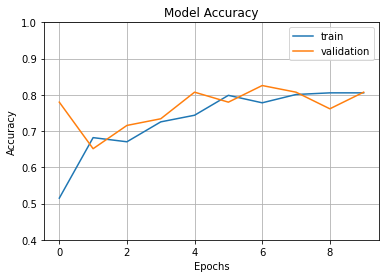

In [30]:
fig1 = plt.gcf()
plt.plot(history_InceptionV3.history['accuracy'])
plt.plot(history_InceptionV3.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

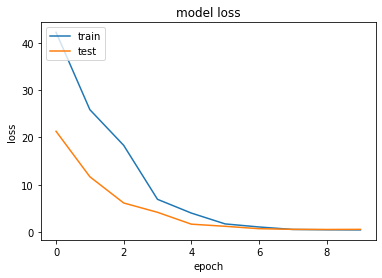

In [31]:
# summarize history for loss
plt.plot(history_InceptionV3.history['loss'])
plt.plot(history_InceptionV3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()